In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


# Exploratory Data Analysis

In [2]:
# Load the dataset
housing_data = pd.read_csv('Housing.csv')

# Check for missing values
print(housing_data.isnull().sum())

# Descriptive statistics
print(housing_data.describe())

# Replace 'yes' with 1 and 'no' with 0 across all relevant columns
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Applying the transformation
housing_data[binary_columns] = housing_data[binary_columns].replace({'yes': 1, 'no': 0})

housing_data['furnishingstatus'] = housing_data['furnishingstatus'].replace({'furnished': 10, 'semi-furnished': 5, 'unfurnished': 0})

# Verifying the change
housing_data.head()


price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mea

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,10
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,10
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,5
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,10
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,10


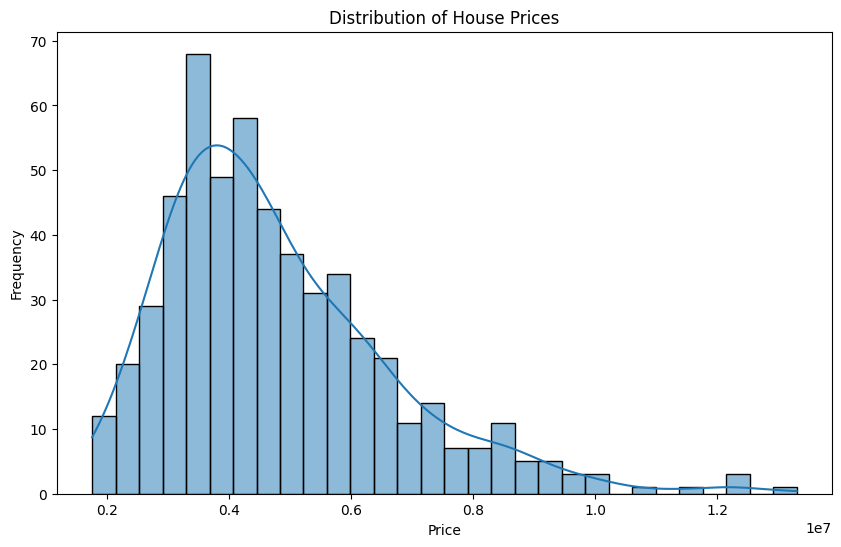

In [3]:
plt.figure(figsize=(10,6))
sns.histplot(housing_data['price'], kde=True, bins=30)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [4]:
# Standardizing numerical features
numerical_cols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
scaler = StandardScaler()

# Apply scaling
housing_data[numerical_cols] = scaler.fit_transform(housing_data[numerical_cols])


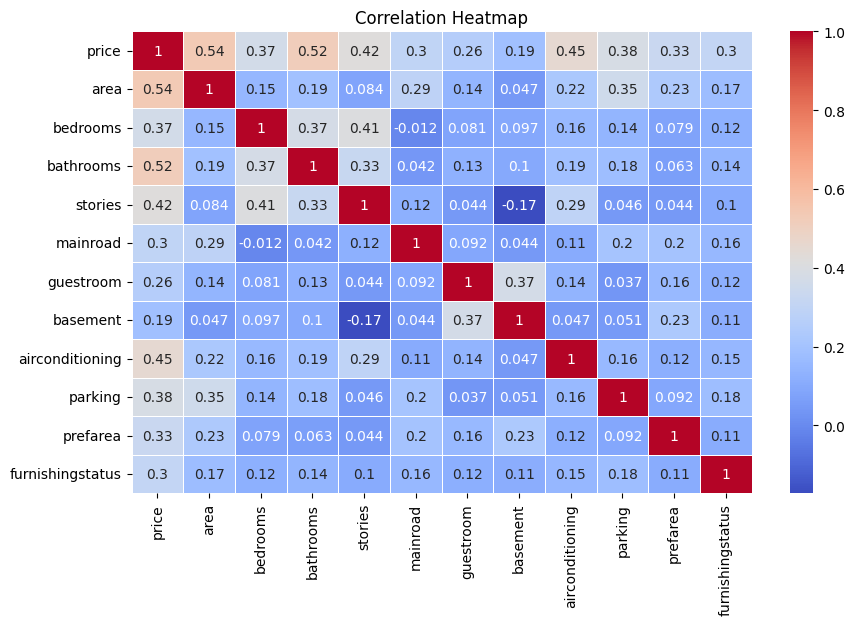

In [5]:
housing_data = housing_data.drop(columns=['hotwaterheating'])

corr_matrix = housing_data.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [6]:
# Features (dropping the target and hotwaterheating column)
X = housing_data.drop(columns=['price'], axis=1)

# Target variable
y = housing_data['price']

# Convert categorical variables into dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X)

print(f"Original dimensions: {X.shape[1]}, Reduced dimensions: {X_pca.shape[1]}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=500)

Original dimensions: 11, Reduced dimensions: 6


# Models

## Supervised Learning

### Linear Regression

In [7]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions and Metrics
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression:")
print(f"Mean Squared Error: {mse_lr}")
print(f"R^2 Score: {r2_lr}")


Linear Regression:
Mean Squared Error: 1081694078415.4677
R^2 Score: 0.6225714210548972


### KNN Regression

In [8]:
# KNN Regressor with GridSearchCV
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': range(10, 15)}
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='r2', verbose=1)
grid_search_knn.fit(X_train, y_train)

# Best Parameters and Metrics
print("Best Parameters for KNN:", grid_search_knn.best_params_)
knn_best = grid_search_knn.best_estimator_
y_pred_knn = knn_best.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("KNN Regression:")
print(f"Mean Squared Error: {mse_knn}")
print(f"R^2 Score: {r2_knn}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for KNN: {'n_neighbors': 11}
KNN Regression:
Mean Squared Error: 1317617842987.7778
R^2 Score: 0.5402520546289076


### Decision Tree Regression

In [15]:
# Define the parameter grid
param_grid_dt = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],  
    'min_samples_leaf': [6, 7, 8],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']  
}

# Initialize the Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=500)

# Perform GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=5, scoring='r2', verbose=1)
grid_search_dt.fit(X_train, y_train)

# Retrieve the best parameters and score
print("Best Parameters for Decision Tree Regression:", grid_search_dt.best_params_)
print("Best R^2 Score for Decision Tree Regression:", grid_search_dt.best_score_)

# Make predictions using the best estimator
dt_best = grid_search_dt.best_estimator_
y_pred_dt = dt_best.predict(X_test)

# Evaluate the optimized Decision Tree
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Optimized Decision Tree Regression:")
print(f"Mean Squared Error: {mse_dt}")
print(f"R^2 Score: {r2_dt}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters for Decision Tree Regression: {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best R^2 Score for Decision Tree Regression: 0.4574009840037391
Optimized Decision Tree Regression:
Mean Squared Error: 1949731757137.0942
R^2 Score: 0.31969259968737085


### Random Forest Regression

In [14]:
# Random Forest Regressor with GridSearchCV
param_grid_rf = {
    'n_estimators': [179, 180, 181], 
    'max_depth': [6, 7], 
    'min_samples_split': [2],  
    'min_samples_leaf': [2, 3], 
    'criterion': ['friedman_mse', 'squared_error', 'absolute_error']
}

rf = RandomForestRegressor(random_state=500)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='r2', verbose=1)
grid_search_rf.fit(X_train, y_train)

# Best Parameters and Metrics
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
rf_best = grid_search_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R^2 Score: {r2_rf}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Random Forest: {'criterion': 'absolute_error', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 180}
Random Forest Regression:
Mean Squared Error: 1289259779901.8618
R^2 Score: 0.5501468517492092


## Unsupervised Learning

### KMeans Custering

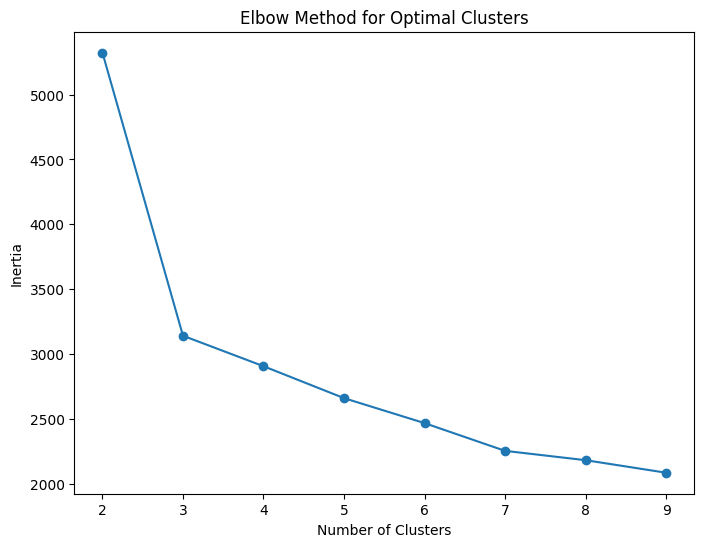

Silhouette Scores for KMeans: [0.4511095019866689, 0.4674055284499429, 0.4168066890092899, 0.3049598381853612, 0.31445269881944843, 0.25164544778979525, 0.2509625768140374, 0.22841983519555545]


In [11]:
# Finding Optimal Clusters using Elbow Method
inertia = []
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=500)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

print("Silhouette Scores for KMeans:", silhouette_scores)


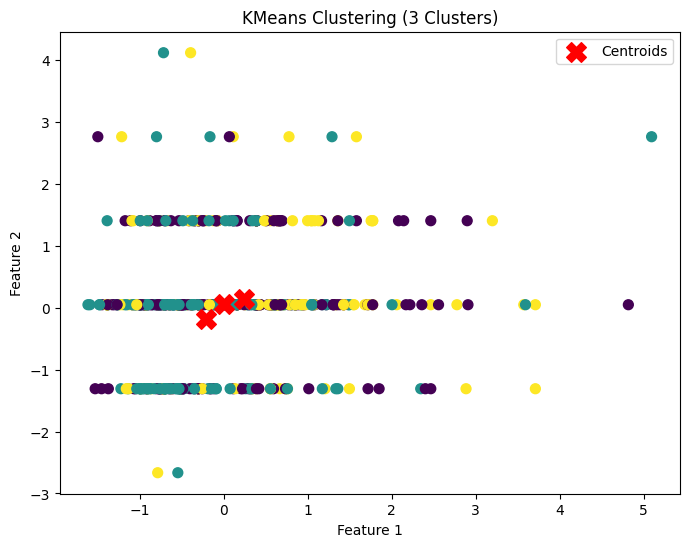

In [12]:
# Apply KMeans with 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=500)
housing_data['Cluster'] = kmeans_3.fit_predict(X)

# Scatter plot for clustering visualization
plt.figure(figsize=(8, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=housing_data['Cluster'], cmap='viridis', s=50)
plt.scatter(kmeans_3.cluster_centers_[:, 0], kmeans_3.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('KMeans Clustering (3 Clusters)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### Hierarchical Clustering

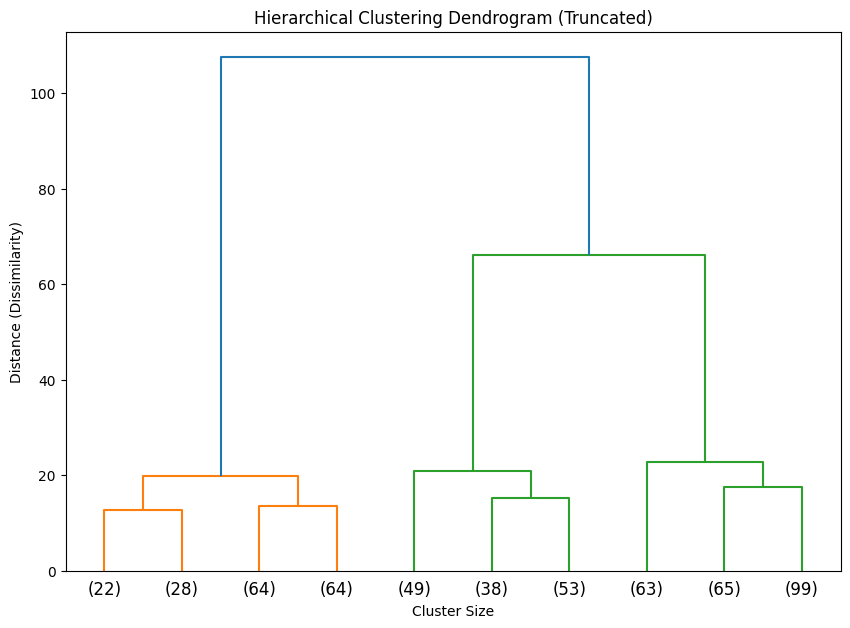

In [13]:
# Recompute linkage for hierarchical clustering
linked = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=10)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance (Dissimilarity)')
plt.show()